## <center> Практическое домашнее задание 2 </center>

*`credits to ML course by E. Sokolov`*

### Общая информация

Дата выдачи: 23.02.2025

Первый дедлайн: 07:59MSK 22.03.2025

Второй дедлайн: 07:59MSK 24.03.2025

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

**Штраф за каждый день просрочки мягкого дедлайна**: 0.5 баллов. После жесткого дедлайна работы не принимаются.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник.

### Формат сдачи
Задания сдаются через яндекс-форму в чате курса. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
!pip install folium

In [ ]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Введение

*эта часть - введение в задачу, баллов за нее не предусмотрено - она исключительно, чтобы помочь вам :-)*

Решение любой задачи, связанной с машинным обучением, начинается с разведочного анализа данных. Перед тем, как строить модели, надо понять, сколько у нас данных и какая информация есть о каждом объекте, а также:
* выяснить, нет ли пропусков в данных (т.е. отсутствующих значений признаков у некоторых объектов)
* выяснить, нет ли выбросов (т.е. объектов, которые очень сильно отличаются от большинства, имеют неадекватные значения признаков)
* выяснить, нет ли повторов в данных
* выяснить, нет ли нелогичной информации (например, если мы анализируем данные по кредитам, и видим запись, где кредит выдали пятилетнему ребёнку, то это странно)

И это лишь небольшой список проблем, которые можно выявить. Помимо этого с данными нужно в целом познакомиться, чтобы понять, какие признаки там можно сделать, какие из них будут наиболее полезны.

Попробуем провести такой анализ на реальной задаче предсказания продолжительности поездки на такси в Нью-Йорке:

In [ ]:
!wget  -O 'train.csv' -q 'https://www.dropbox.com/s/en5f9nhn915cnkf/_train.csv?dl=0'

train = pd.read_csv('train.csv')
train.head()

id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731152                  N            663  
2         40.710087                  N           2124  
3         40.706718                  N            429  
4         40.782520                  N            435

Смысл столбцов:

* id - идентификатор поездки
* vendor_id - код провайдера, от которого пришла информация о поездке
* pickup_datetime - время старта поездки
* dropoff_datetime - время окончания поездки
* passenger_count - число пассажиров (вводится водителем)
* pickup_longitude - долгота точки посадки
* pickup_latitude - широта точки посадки
* dropoff_longitude - долгота точки высадки
* dropoff_latitude - долгота точки высадки
* store_and_fwd_flag - равно Y, если информация о поездке какое-то время хранилась в памяти таксометра из-за отсутствия связи; иначе принимает значение N
* trip_duration - продолжительность поездки в секундах

Посмотрим внимательно на столбцы из нашей таблицы и попробуем проверить, нет ли там противоречий и проблем. Например, в голову приходят следующие вопросы:
* можно ли считать ID уникальным идентификатором поездки, или же есть записи с одинаковыми ID?
* есть ли где-то пропуски?
* действительно ли столбец store_and_fwd_flag принимает только значения Y и N?

In [ ]:
print('Id is unique.') if train.id.nunique() == train.shape[0] else print('oops')
print('We do not need to worry about missing values.') if train.count().min() == train.shape[0] else print('oops')
print('The store_and_fwd_flag has only two values {}.'.format(str(set(train.store_and_fwd_flag.unique()))))

Id is unique.
We do not need to worry about missing values.
The store_and_fwd_flag has only two values {'Y', 'N'}.


In [ ]:
train.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Видно, что pandas отнёс столбцы с датами к общему типу object. Будет лучше привести их к типу datetime, чтобы использовать удобные функции для манипуляций с датами. Заодно сделаем проверку — действительно ли столбец check_trip_duration показывает продолжительность поездки, или же он входит в противоречие со столбцами pickup_datetime и dropoff_datetime.

In [ ]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')
train['check_trip_duration'] = (train['dropoff_datetime'] - train['pickup_datetime']).map(lambda x: x.total_seconds())
duration_difference = train[np.abs(train['check_trip_duration'].values  - train['trip_duration'].values) > 1]
print('Trip_duration and datetimes are ok.') if len(duration_difference[['pickup_datetime', 'dropoff_datetime', 'trip_duration', 'check_trip_duration']]) == 0 else print('Ooops.')

Trip_duration and datetimes are ok.


In [ ]:
train.head()

id  vendor_id     pickup_datetime    dropoff_datetime  \
0  id2875421          2 2016-03-14 17:24:55 2016-03-14 17:32:30   
1  id2377394          1 2016-06-12 00:43:35 2016-06-12 00:54:38   
2  id3858529          2 2016-01-19 11:35:24 2016-01-19 12:10:48   
3  id3504673          2 2016-04-06 19:32:31 2016-04-06 19:39:40   
4  id2181028          2 2016-03-26 13:30:55 2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude  store_and_fwd_flag  trip_duration pickup_date  \
0         40.765602                   0            455  2016-03-14   
1         40.731152                   0            663  2016-06-12   
2         40.710087                   0           2124  2016-01-19   
3         40.706718                   0            429  2016-04-06   
4         40.782520                   0            435  2016-03-26   

   check_trip_duration  
0                455.0  
1                663.0  
2               2124.0  
3                429.0  
4                435.0

Ещё имеет смысл проверить целевую переменную trip_duration. Нет ли там выбросов? Какими по продолжительности бывают поездки? Выглядит ли распределение этой переменной осмысленно?

Когда в каком-то столбце распределение имеет тяжёлые хвосты или есть выбросы, обычные гистограммы не очень информативны. В этом случае может быть полезно нарисовать распределение в логарифмической шкале.

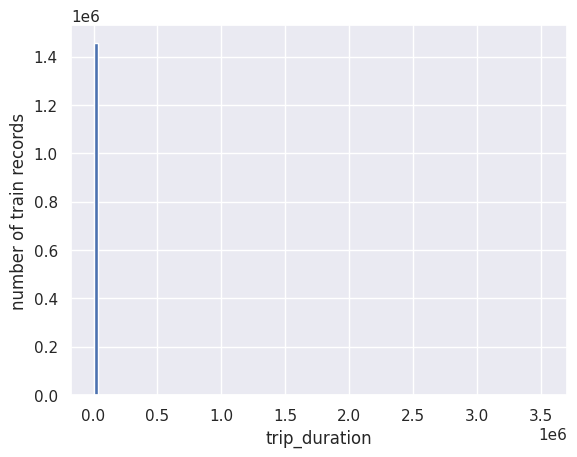

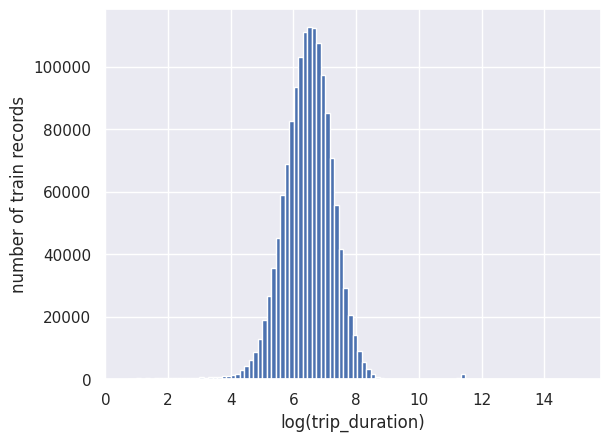

In [ ]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

train['log_trip_duration'] = np.log1p(train['trip_duration'].values)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

In [ ]:
print("В секундах:", np.exp(5), np.exp(9))
print("В минутах:", np.exp(5) // 60, np.exp(9) // 60)

В секундах: 148.4131591025766 8103.083927575384
В минутах: 2.0 135.0


Кандидатов на выбрасывание не так уж много — например, если взять поездки длиной 10 часа и больше, то их окажется около двух тысяч, и определённо надо выяснять, что это такое.

In [ ]:
train[train.trip_duration >= 10 * 3600]

id  vendor_id     pickup_datetime    dropoff_datetime  \
531      id3307903          2 2016-02-20 04:03:06 2016-02-21 03:33:00   
1134     id1091477          2 2016-05-07 18:36:22 2016-05-08 18:32:11   
1865     id3431345          2 2016-06-07 12:58:48 2016-06-08 12:58:00   
3442     id1487069          2 2016-02-13 00:21:49 2016-02-14 00:19:05   
4172     id3674870          2 2016-03-18 11:54:20 2016-03-19 11:34:17   
...            ...        ...                 ...                 ...   
1455097  id2798196          2 2016-03-20 03:51:36 2016-03-21 00:00:00   
1456458  id2055880          2 2016-02-08 19:11:31 2016-02-09 19:08:44   
1457207  id1910950          2 2016-06-08 16:29:12 2016-06-09 16:11:03   
1457752  id1215198          2 2016-02-02 11:31:10 2016-02-03 11:29:44   
1458076  id2332290          2 2016-04-24 00:58:34 2016-04-25 00:56:16   

         passenger_count  pickup_longitude  pickup_latitude  \
531                    3        -74.008102        40.741489   
1134                   1        -73.990242        40.750919   
1865                   6        -73.954956        40.777649   
3442                   1        -73.968590        40.799217   
4172                   1        -73.989090        40.736992   
...                  ...               ...              ...   
1455097                2        -73.969299        40.757301   
1456458                3        -73.973282        40.760792   
1457207                1        -73.958061        40.800869   
1457752                6        -73.972069        40.794220   
1458076                1        -73.990479        40.760876   

         dropoff_longitude  dropoff_latitude  store_and_fwd_flag  \
531             -74.009956         40.714611                   0   
1134            -73.976280         40.750889                   0   
1865            -73.981033         40.743713                   0   
3442            -73.979584         40.784714                   0   
4172            -73.972336         40.751511                   0   
...                    ...               ...                 ...   
1455097         -73.870277         40.709808                   0   
1456458         -73.988518         40.764210                   0   
1457207         -73.964119         40.805515                   0   
1457752         -73.961014         40.806728                   0   
1458076         -73.983025         40.764557                   0   

         trip_duration pickup_date  check_trip_duration  log_trip_duration  
531              84594  2016-02-20              84594.0          11.345630  
1134             86149  2016-05-07              86149.0          11.363845  
1865             86352  2016-06-07              86352.0          11.366199  
3442             86236  2016-02-13              86236.0          11.364855  
4172             85197  2016-03-18              85197.0          11.352733  
...                ...         ...                  ...                ...  
1455097          72504  2016-03-20              72504.0          11.191411  
1456458          86233  2016-02-08              86233.0          11.364820  
1457207          85311  2016-06-08              85311.0          11.354070  
1457752          86314  2016-02-02              86314.0          11.365759  
1458076          86262  2016-04-24              86262.0          11.365156  

[2012 rows x 14 columns]

Попробуем нарисовать, откуда обычно стартуют поездки.

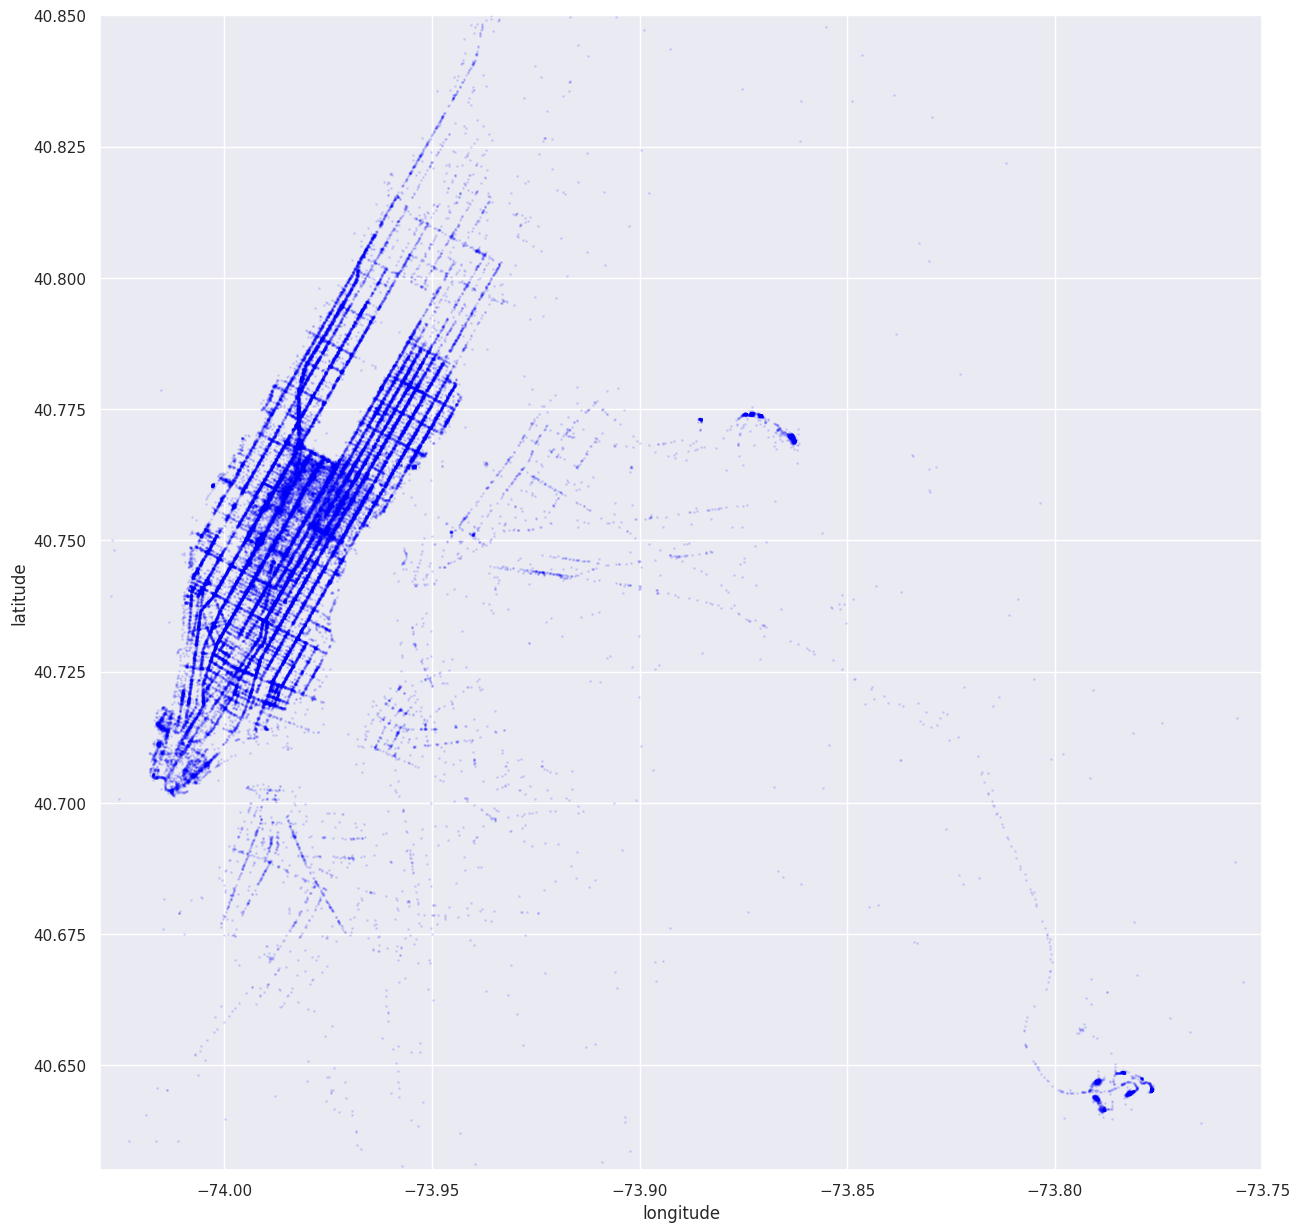

In [ ]:
N = 100000
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
plt.figure(figsize=(15,15))
plt.scatter(train['pickup_longitude'].values[:N], train['pickup_latitude'].values[:N],
              color='blue', s=1, label='train', alpha=0.1)
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.ylim(city_lat_border)
plt.xlim(city_long_border)
plt.show()

In [ ]:
from ipyleaflet import Map, Circle, LayerGroup, basemaps

def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    center = (data[latitude_column].mean(), data[longitude_column].mean())
    result_map = Map(center=center, zoom=10, basemap=basemaps.Esri.NatGeoWorldMap)

    circles = []
    for _, row in data.iterrows():
        circles.append(Circle(
            location=(row[latitude_column], row[longitude_column]),
            fill_color=color,
            fill_opacity=0.2,
            radius=300,
            stroke=False
        ))
    circles_layer = LayerGroup(layers=circles)
    result_map.add_layer(circles_layer)

    return result_map

show_circles_on_map(train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

Map(center=[np.float64(40.750552330017086), np.float64(-73.97354724121094)], controls=(ZoomControl(options=['p…

Кстати, случайный ли порядок записей в таблице? Это важно понимать, например, для разбиения выборки на обучающую и тестовую части. Если порядок не является случайным, а мы отнесём к обучающей части первую половину таблицы, то есть риск, что данные в обучении и тесте будут иметь разные распределения, а значит, модель сможет хорошо работать только на одной из частей.

Text(0, 0.5, 'Дней с момента ранней поездки')

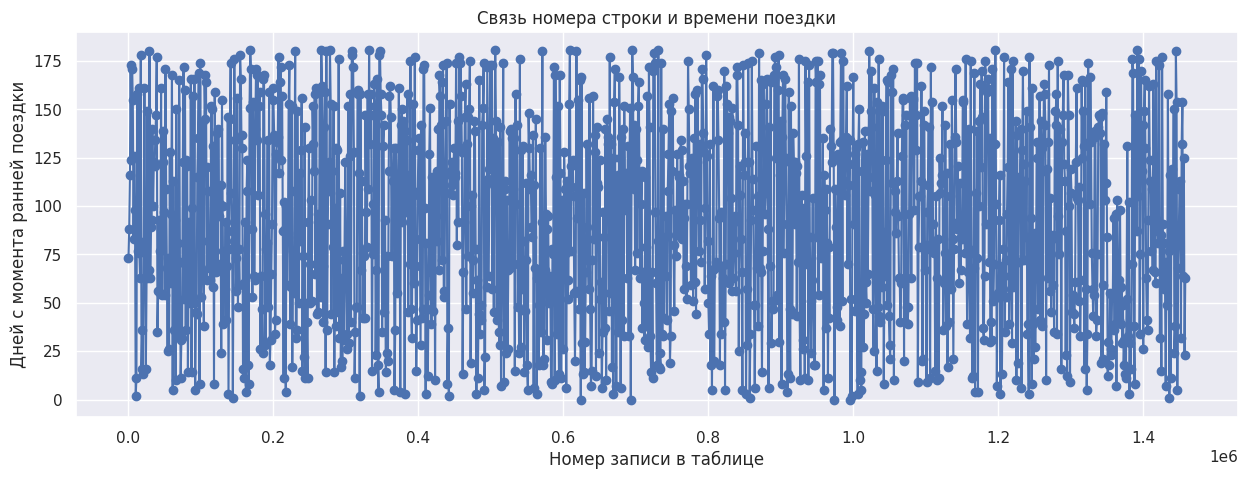

In [ ]:
plt.figure(figsize=(15,5))
days_since_min_ride = (train['pickup_datetime'] - train['pickup_datetime'].min()).apply(lambda x: x.total_seconds() // (60*60*24))
plt.plot(days_since_min_ride[::1000], 'o-')
plt.title('Связь номера строки и времени поездки')
plt.xlabel('Номер записи в таблице')
plt.ylabel('Дней с момента ранней поездки')

Вроде бы всё довольно случайно.

Посчитаем какие-нибудь признаки. Скорее всего продолжительность поездки неплохо зависит от расстояния — посчитаем его. Кстати, важно заметить, что само расстояние не может быть признаком, поскольку в тестовой выборке нет информации о пункте назначения. Но мы пока исследуем данные и, может, увидим в расстояниях что-то интересное.

Можно выбрать научный подход и посчитать честное расстояние на сфере между двумя точками. Это называется haversine distance.

Можно решить, что Земля плоская, и считать стандартные расстояния. В этом случае очень неплохо подойдёт манхэттенское расстояние — оно учитывает, что машины всё-таки не летают.



In [ ]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'distance_dummy_manhattan'] = dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

Обсудим немного скорость вычислений в pandas. Есть несколько способов применить функцию к каждой строке в таблице. Если вы до этого изучали преимущественно C/C++, то первое, что должно прийти вам в голову, — написать цикл.

In [ ]:
%%timeit

for i in range(100):
    train[i, 'distance_haversine'] = haversine_array(train['pickup_latitude'].iloc[i],
                                                      train['pickup_longitude'].iloc[i],
                                                      train['dropoff_latitude'].iloc[i],
                                                      train['dropoff_longitude'].iloc[i])

<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
<magic-timeit>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame

174 ms ± 4.41 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Обратите внимание, что мы посчитали расстояния всего лишь для первых 100 записей, и это уже было не очень быстро.

Можно воспользоваться функцией apply.

In [ ]:
%%timeit

train.iloc[:5000, :].apply(lambda x:
                            haversine_array(x['pickup_latitude'],
                                            x['pickup_longitude'],
                                            x['dropoff_latitude'],
                                            x['dropoff_longitude']),
                            axis=1)

186 ms ± 40 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


За то же самое время мы успеваем обработать уже 5000 записей, а не 100.

Но лучший способ — это векторизовать вычисления. Подробнее об этом мы будем говорить на следующих семинарах.

In [ ]:
%%timeit
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values,
                                                     train['pickup_longitude'].values,
                                                     train['dropoff_latitude'].values,
                                                     train['dropoff_longitude'].values)

148 ms ± 35.5 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Часть 0. Подготовка (1.5 балла)

**Задание 1 (1.5 балла)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

*1.5 балла - за всю эту часть*

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

!pip install -q kaggle
from google.colab import files
!mkdir -p ~/.kaggle
!wget --no-check-certificate 'https://raw.githubusercontent.com/terinkov/sorces/refs/heads/main/kaggle.json' -O ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
# !chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c nyc-taxi-trip-duration -p sample_data
# df = pd.read_csv("train.csv")
# df.head()
import zipfile
import os

# Распаковка в текущую директорию
with zipfile.ZipFile("/content/sample_data/nyc-taxi-trip-duration.zip", "r") as zip_ref:
    zip_ref.extractall("/content/sample_data")  # Распаковка в sample_data

# Пути к архивам внутри sample_data
train_zip_path = "/content/sample_data/train.zip"
test_zip_path = "/content/sample_data/test.zip"
extract_to = "/content/sample_data/"

# Распаковка train.zip
with zipfile.ZipFile(train_zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_to)

# Распаковка test.zip
with zipfile.ZipFile(test_zip_path, "r") as zip_ref:
    zip_ref.extractall(extract_to)

df = pd.read_csv("/content/sample_data/train.csv")
test_df = pd.read_csv("/content/sample_data/test.csv")


--2025-03-21 22:21:33--  https://raw.githubusercontent.com/terinkov/sorces/refs/heads/main/kaggle.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 69 [text/plain]
Saving to: ‘/root/.kaggle/kaggle.json’

/root/.kaggle/kaggl 100%[===================>]      69  --.-KB/s    in 0s      

2025-03-21 22:21:33 (4.46 MB/s) - ‘/root/.kaggle/kaggle.json’ saved [69/69]

ref                                                                    title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
---------------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Удаляем колонку dropoff_datetime
df.drop(columns=["dropoff_datetime"], inplace=True)

# Преобразуем pickup_datetime в datetime-формат
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

# Проверим изменения
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 10 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1458644 non-null  object        
 1   vendor_id           1458644 non-null  int64         
 2   pickup_datetime     1458644 non-null  datetime64[ns]
 3   passenger_count     1458644 non-null  int64         
 4   pickup_longitude    1458644 non-null  float64       
 5   pickup_latitude     1458644 non-null  float64       
 6   dropoff_longitude   1458644 non-null  float64       
 7   dropoff_latitude    1458644 non-null  float64       
 8   store_and_fwd_flag  1458644 non-null  object        
 9   trip_duration       1458644 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(2)
memory usage: 111.3+ MB


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

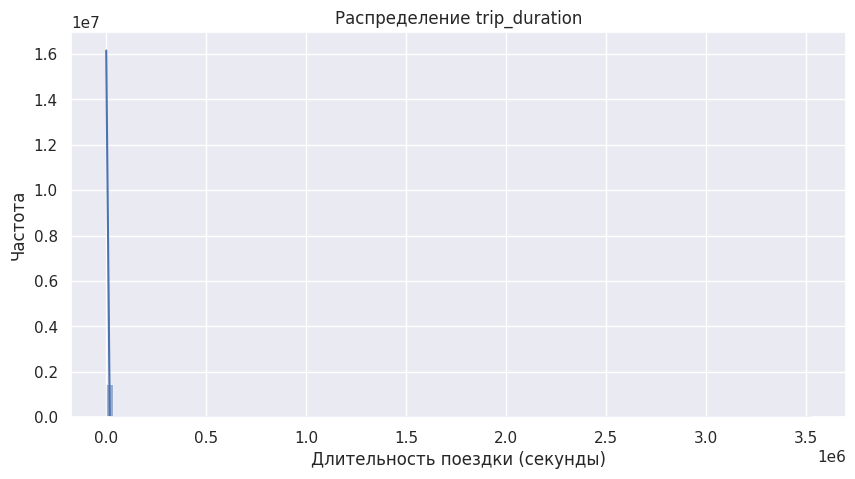

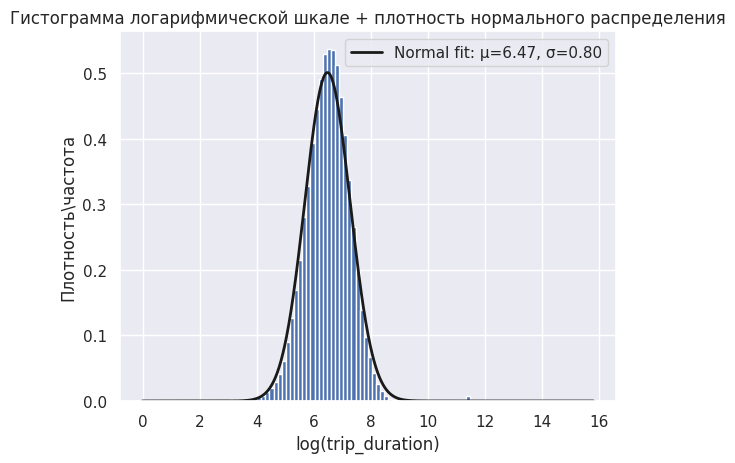

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Построим гистограмму таргета

# В исходной шкале ( в секундах )
plt.figure(figsize=(10, 5))
ax = sns.histplot(df["trip_duration"], bins=100, kde=True)
plt.xlabel("Длительность поездки (секунды)")
plt.ylabel("Частота")
plt.title("Распределение trip_duration")
plt.show()

# В логарифмической шкале + плотность нормального распределения
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import seaborn as sns



train = df.copy()
train['log_trip_duration'] = np.log1p(train['trip_duration'].values)
plt.hist(train['log_trip_duration'].values, bins=100, density=True)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')

# Подбор параметров нормального распределения
mu, std = norm.fit(train['log_trip_duration'].values)  # mu - среднее, std - стандартное отклонение

# Генерация точек для построения плотности нормального распределения
xmin, xmax = plt.xlim()  # Границы графика по оси X
x = np.linspace(xmin, xmax, 1000)  # Точки для построения кривой
p = norm.pdf(x, mu, std)  # Плотность нормального распределения

# Построение кривой плотности
plt.plot(x, p, 'k', linewidth=2, label=f'Normal fit: μ={mu:.2f}, σ={std:.2f}')

# Добавление подписей и легенды
plt.xlabel('log(trip_duration)')
plt.ylabel('Плотность\частота')
plt.title('Гистограмма логарифмической шкале + плотность нормального распределения')
plt.legend()

# Показать график
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

*   Поездки, в целом, занимают от e^4 ~ 50 секунд, до e^9 ~ 135 минут (примерно 2 часа 15 минут).
*   Однако есть несколько поездок (по гистограмме), занимающих e^10 ~  6 часов
*   Целевая переменная имеет, по всей видимости, смещенное лог-нормальное распределение. Такой вывод можно сделать по виду функции плотности распределения log(1+trip_duration). То есть так как log(1+trip_duration) имеет похожее на нормальное распределение, значит 1+trip_duration имеет Логнормальное распредлеение, и trip_duration имеет смещенное Логнормальное распределение.



В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

Преимущества RMSLE:

*   Уменьшает влияние аномально больших значений (см. гистограмму выше).
*   Фокусируется на относительных ошибках, а не на абсолютных.

Почему не RMSE.

*   Вообще логика RMSLE - минимизировать **относительные** ошибки, а не абсолютные как RMSE. К примеру: ошибиться на 10 минут при короткой поездке (5 мин) — серьёзная ошибка, ошибиться на 10 минут при длинной поездке (2 часа) — не так страшно.
*   Как мы уже увидели, в train есть поездки, длиннее 6 часов, которые могут быть и выбросами. RMSLE в отличие от RMSE **снижает влияние выбросов**, поскольку "карает" за ошибку на выбросе (огромную ошибку) на логарифм от значения, а не само значение.
*   Как мы уже увидели, логарифм от trip_duration распределен нормально, а это значит сама trip_duration распределена логнормально. Поэтому логично выбрать ошибку, связанную с логарифмом значения, а не с самими исходными значениями, поскольку тогда долгие поездки влияли бы слишком сильно, а которкие - слишком слабо.

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

Мы смогли свести задачу оптимизации RMSLE к эквивалентной задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

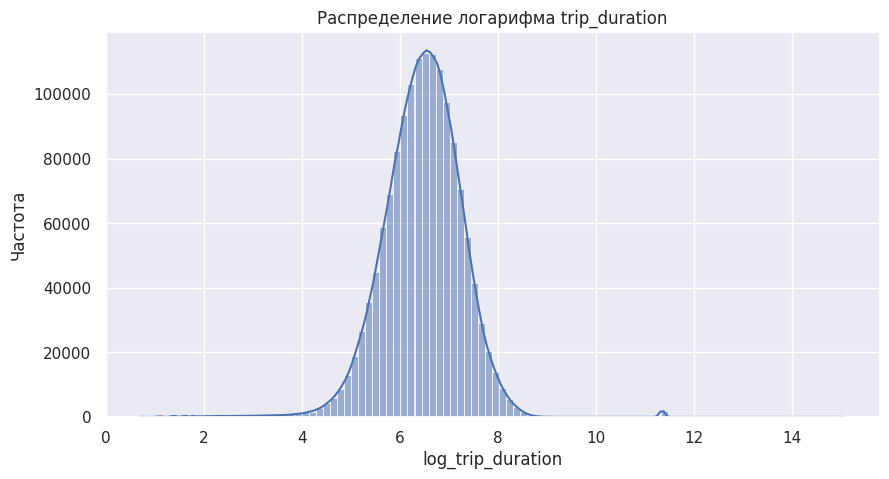

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df["log_trip_duration"] = np.log1p(df["trip_duration"])

# Рисуем новую гистограмму
plt.figure(figsize=(10, 5))
sns.histplot(df["log_trip_duration"], bins=100, kde=True)
plt.xlabel("log_trip_duration")
plt.ylabel("Частота")
plt.title("Распределение логарифма trip_duration")
plt.show()

# Удаляем старый таргет
df.drop(columns=["trip_duration"], inplace=True)


Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [ ]:
from sklearn.metrics import mean_squared_error

def rmsle(log1p_y_true, log1p_y_pred):
    #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
    return np.sqrt(mean_squared_error(log1p_y_true, log1p_y_pred))

    raise NotImplementedError

# Лучшее константное предсказание — среднее логарифма
best_const_pred = df["log_trip_duration"].mean()

# Вычисляем RMSLE
rmsle_best_const = rmsle(df["log_trip_duration"], np.full_like(df["log_trip_duration"], best_const_pred))

print("Лучшее RMSLE константного предсказания:", rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

#assert сработал, значит не вызывает ошибку (assert как проверка)

Лучшее RMSLE константного предсказания: 0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2.5 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

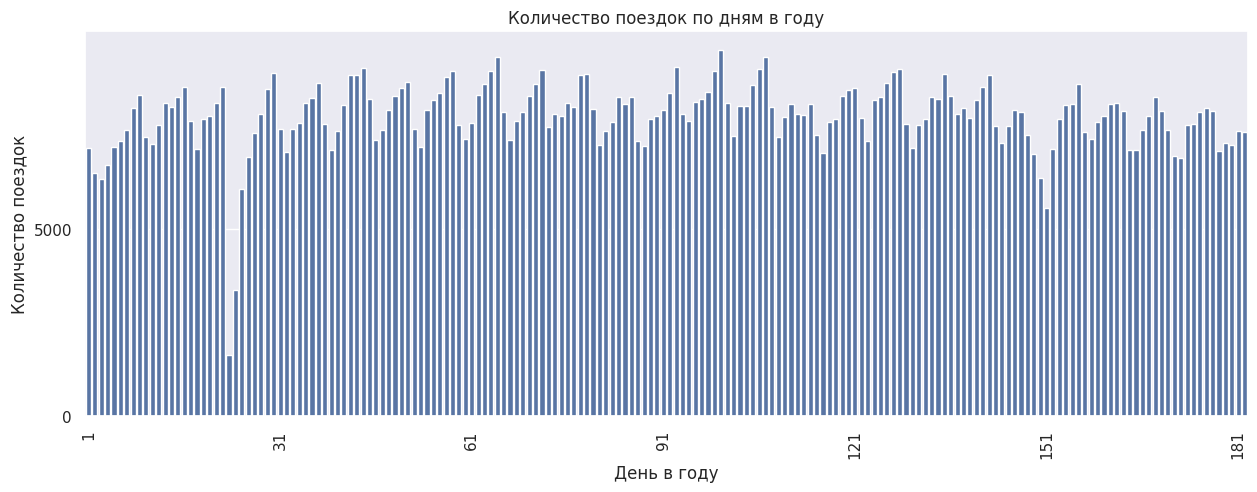

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
plt.figure(figsize=(15, 5))
ax =sns.countplot(x=df["pickup_datetime"].dt.dayofyear)
# Настроим метки осей X и Y
ax.set_xticks(range(0, 181, 30))  # Шаг 30 дней (примерно 1 месяц)
plt.xticks(rotation=90)
ax.set_yticks(range(0, df["pickup_datetime"].dt.dayofyear.value_counts().max(), 5000))  # Шаг 5000 поездок
plt.xlabel("День в году")
plt.ylabel("Количество поездок")
plt.title("Количество поездок по дням в году")
plt.show()

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [ ]:
import pandas as pd

# Преобразуем pickup_datetime в datetime-формат
df["pickup_datetime"] = pd.to_datetime(df["pickup_datetime"])

# Группируем данные по дню и считаем количество поездок
daily_counts = df["pickup_datetime"].dt.date.value_counts().sort_values()

# Выбираем 5 дней с наименьшим числом поездок
anomalous_days = daily_counts.head(5)

# Выводим даты и количество поездок
print(anomalous_days)


pickup_datetime
2016-01-23    1648
2016-01-24    3383
2016-05-30    5570
2016-01-25    6084
2016-01-03    6353
Name: count, dtype: int64




*   Вывели даты с аномально низким числом поездок в этот день:
*   23 и 24 января 2016: Гугл дает информацию о разрушительной снежной буре (https://en.wikipedia.org/wiki/Northeastern_United_States)
*   30 мая 2016: Скорее всего забастовка таксистов (https://picturehistory.livejournal.com/10313371.html)



In [ ]:
df.head()

id  vendor_id     pickup_datetime  passenger_count  \
0  id2875421          2 2016-03-14 17:24:55                1   
1  id2377394          1 2016-06-12 00:43:35                1   
2  id3858529          2 2016-01-19 11:35:24                1   
3  id3504673          2 2016-04-06 19:32:31                1   
4  id2181028          2 2016-03-26 13:30:55                1   

   pickup_longitude  pickup_latitude  dropoff_longitude  dropoff_latitude  \
0        -73.982155        40.767937         -73.964630         40.765602   
1        -73.980415        40.738564         -73.999481         40.731152   
2        -73.979027        40.763939         -74.005333         40.710087   
3        -74.010040        40.719971         -74.012268         40.706718   
4        -73.973053        40.793209         -73.972923         40.782520   

  store_and_fwd_flag  log_trip_duration  
0                  N           6.122493  
1                  N           6.498282  
2                  N           7.661527  
3                  N           6.063785  
4                  N           6.077642

In [ ]:
df["pickup_datetime"].dt.dayofweek.head()

0    0
1    6
2    1
3    2
4    5
Name: pickup_datetime, dtype: int32

<Figure size 1000x500 with 0 Axes>

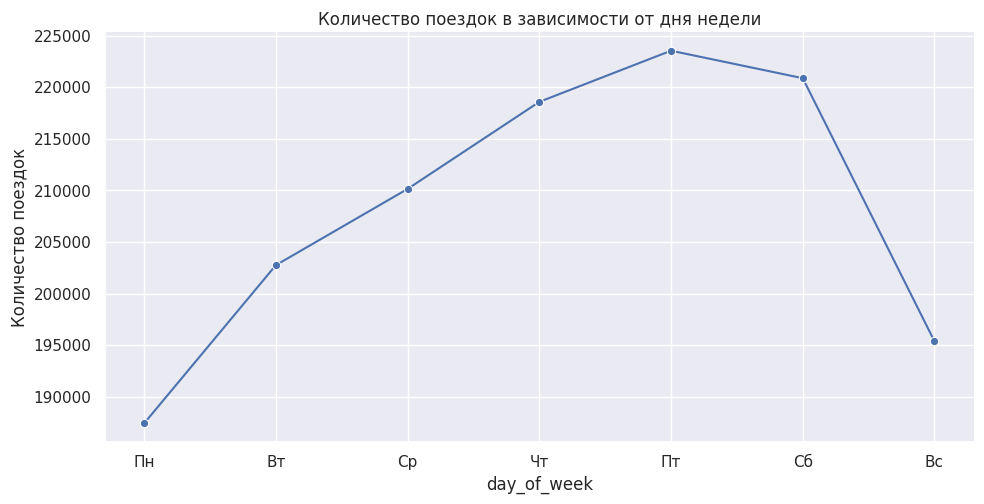

<Figure size 1000x500 with 0 Axes>

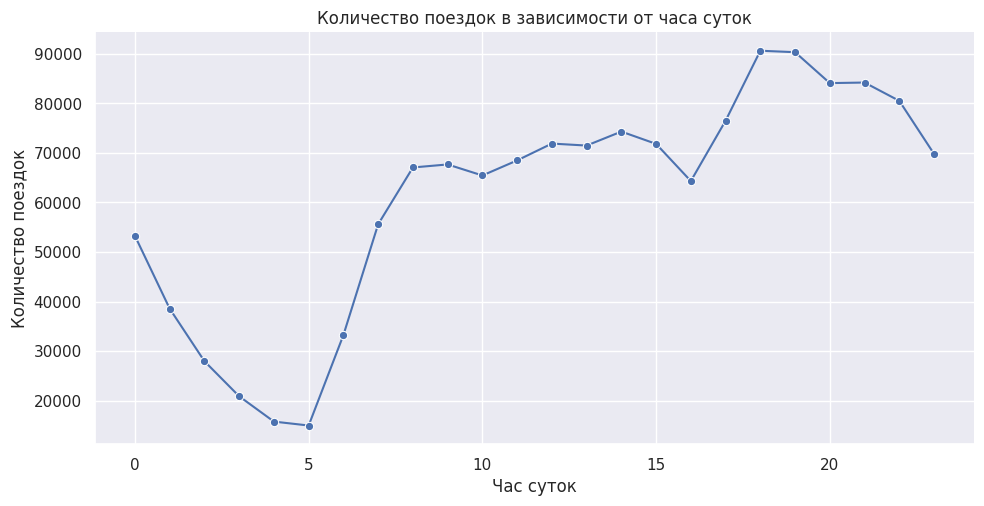

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Добавляем столбцы для анализа
df["day_of_week"] = df["pickup_datetime"].dt.dayofweek  # День недели (0 - Понедельник, 6 - Воскресенье)
df["hour"] = df["pickup_datetime"].dt.hour  # Час суток

# График зависимости количества поездок от дня недели
plt.figure(figsize=(10, 5))
sns.relplot(
    data=df.groupby("day_of_week")["pickup_datetime"].count().reset_index(),
    x="day_of_week",
    y="pickup_datetime",
    kind="line",
    marker="o",
    height=5,
    aspect=2
)
plt.xticks(ticks=range(7), labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.ylabel("Количество поездок")
plt.title("Количество поездок в зависимости от дня недели")
plt.show()

# # График зависимости количества поездок от дня недели
# plt.figure(figsize=(10, 5))
# sns.relplot(
#     data=df.groupby("day_of_week")["log_trip_duration"].mean().reset_index(),
#     x="day_of_week",
#     y="log_trip_duration",
#     kind="line",
#     marker="o",
#     height=5,
#     aspect=2
# )
# plt.xticks(ticks=range(7), labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
# plt.ylabel("Время поездки средний логарифм")
# plt.title("Время поездки средний логарифм")
# plt.show()

# График зависимости количества поездок от часа суток
plt.figure(figsize=(10, 5))
sns.relplot(
    data=df.groupby("hour")["pickup_datetime"].count().reset_index(),
    x="hour",
    y="pickup_datetime",
    kind="line",
    marker="o",
    height=5,
    aspect=2
)
plt.xlabel("Час суток")
plt.ylabel("Количество поездок")
plt.title("Количество поездок в зависимости от часа суток")
plt.show()


**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

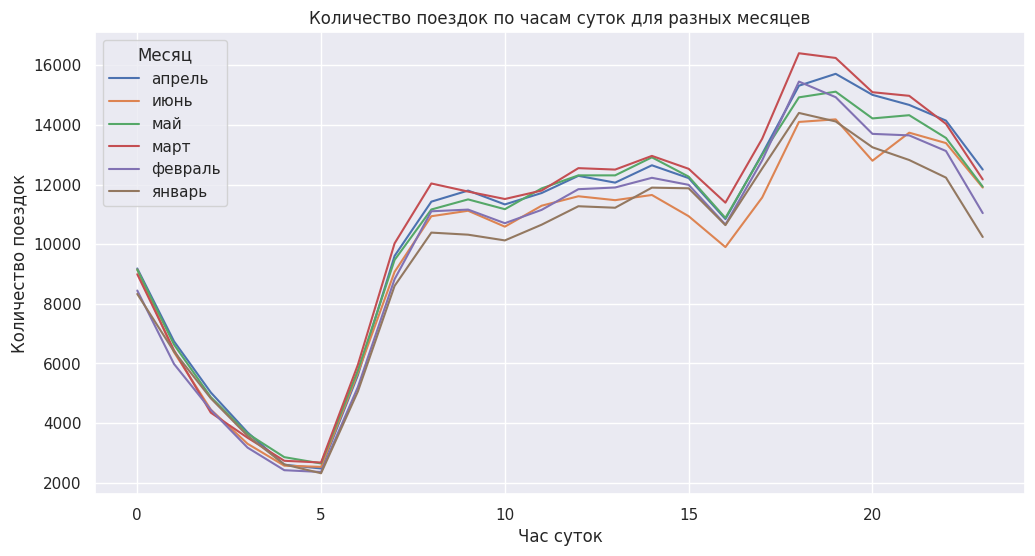

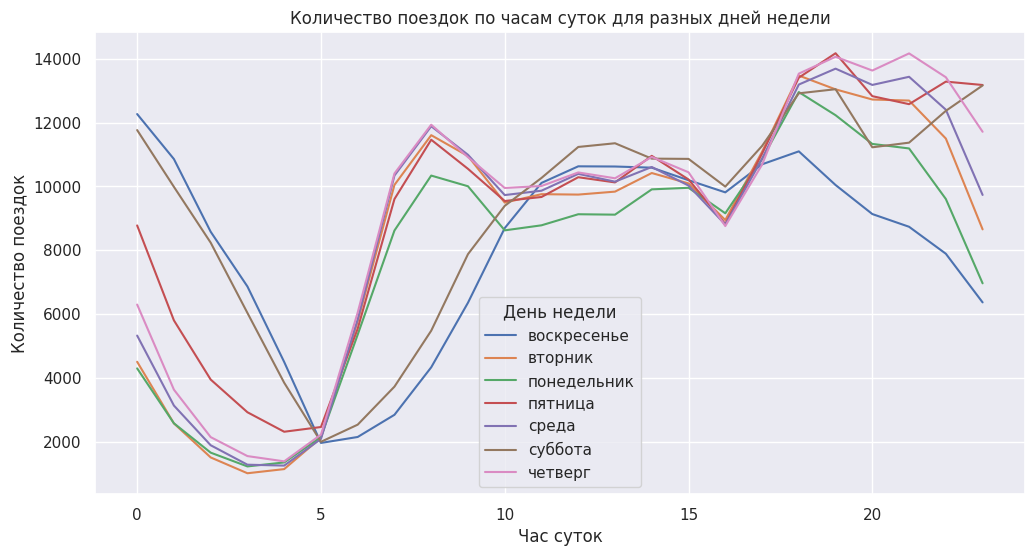

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных
data = pd.read_csv('train.csv')

# Преобразование столбца pickup_datetime в формат datetime
data['pickup_datetime'] = pd.to_datetime(data['pickup_datetime'])

# Создание дополнительных столбцов
data['hour'] = data['pickup_datetime'].dt.hour
data['month'] = data['pickup_datetime'].dt.month
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek

# Словари для замены числовых значений на названия месяцев и дней недели
month_names = {1: 'январь', 2: 'февраль', 3: 'март', 4: 'апрель',
               5: 'май', 6: 'июнь', 7: 'июль', 8: 'август',
               9: 'сентябрь', 10: 'октябрь', 11: 'ноябрь', 12: 'декабрь'}

day_names = {0: 'понедельник', 1: 'вторник', 2: 'среда', 3: 'четверг',
             4: 'пятница', 5: 'суббота', 6: 'воскресенье'}

data['month_name'] = data['month'].map(month_names)
data['day_name'] = data['day_of_week'].map(day_names)

# Группировка данных и подсчет количества поездок для месяцев
month_hour_data = data.groupby(['month_name', 'hour']).size().reset_index(name='num_trips')

# Построение графика для месяцев
plt.figure(figsize=(12, 6))
sns.lineplot(data=month_hour_data, x='hour', y='num_trips', hue='month_name')
plt.title('Количество поездок по часам суток для разных месяцев')
plt.xlabel('Час суток')
plt.ylabel('Количество поездок')
plt.legend(title='Месяц')
plt.show()

# Группировка данных и подсчет количества поездок для дней недели
day_hour_data = data.groupby(['day_name', 'hour']).size().reset_index(name='num_trips')

# Построение графика для дней недели
plt.figure(figsize=(12, 6))
sns.lineplot(data=day_hour_data, x='hour', y='num_trips', hue='day_name')
plt.title('Количество поездок по часам суток для разных дней недели')
plt.xlabel('Час суток')
plt.ylabel('Количество поездок')
plt.legend(title='День недели')
plt.show()


Отвечая на вопрос ниже:

1.   Видна сильная тенденция, говорящая, что на 4:00-5:00 утра приходится минимум по количеству поездок (большинство людей либо вернулось домой, либо спят в это время), тем временем - максимальное число поездок приходится на 18:00-19:00, поскольку в это время у большинства заканчивается работа;

2.   Из первого графика для любого **месяца** верно, что:
*   Ночью (с 1:00 по 5:00) наименьшее число поездок.
*   Утром (6:00-8:00) - значительный рост - люди едут на работу.
*   Днем (9:00-16:00) - число поездок на одинаковом уровне, примерно 11000 на каждый час.
*   Вечером (17:00-20:00) - рост числа поездок, примерно до 14000, так как люди возвращаются с работы.
*   Глубоким вечером (21:00-0:00) - люди возвращаются на такси с прогулок, ресторанов и т.п., поэтому уровень ниже, чем вечером (в 20:00), но выше чем ночью (после 1:00).

3.  По второму графику зависимости от **дня недели** видим сильное различие для кривых, соответствующих Субботе и Воскресенью:
*   Видно, что в эти дни, в отличие от будних дней, люди ведут более активную ночную жизнь, и возвращаются домой в течение всей ночи (высокое число поездок в часы 0:00-4:00). Однако и в течение дня изменения: нет необходимости ехать на работу, поэтому просадка в часы 6:00 - 10:00.



**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (1 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

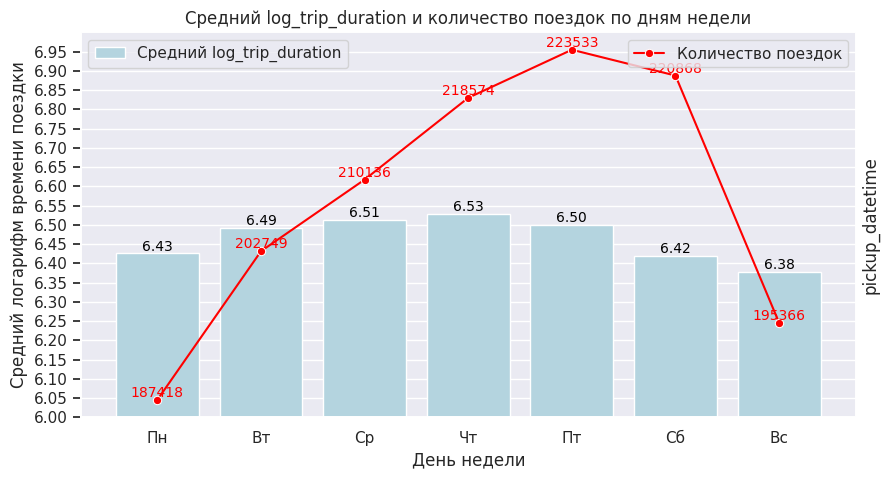

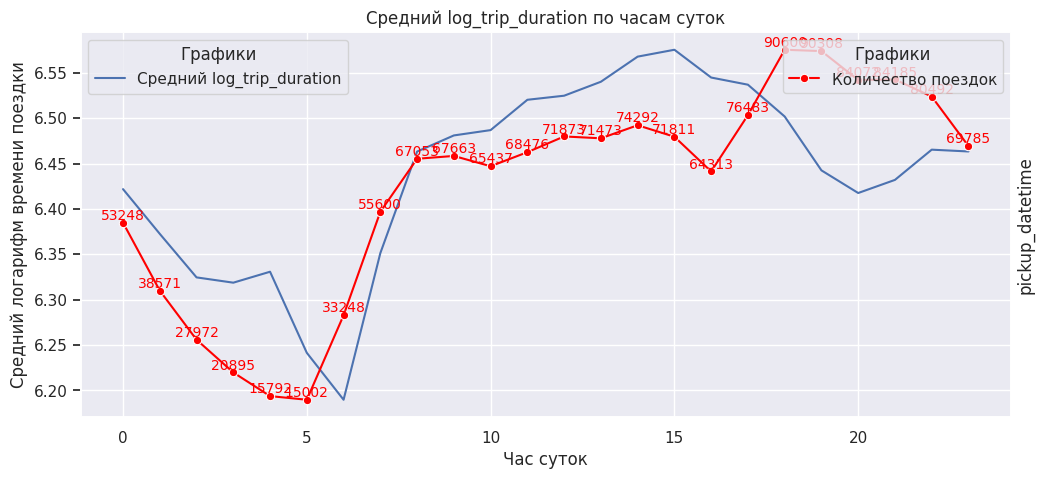

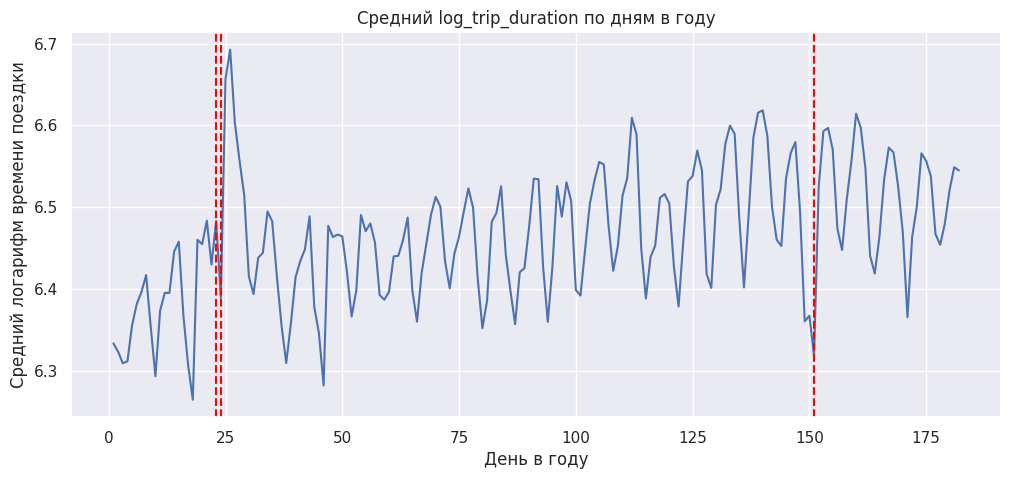

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Разделение выборки на 70% (train) и 30% (test)
train, test = train_test_split(df, test_size=0.3)

# Извлекаем час, день недели и день в году
train["hour"] = train["pickup_datetime"].dt.hour
train["day_of_week"] = train["pickup_datetime"].dt.dayofweek
train["day_of_year"] = train["pickup_datetime"].dt.day_of_year
train["month"] = train["pickup_datetime"].dt.month

plt.figure(figsize=(10, 5))

# Столбчатый график среднего log_trip_duration
ax = sns.barplot(data=train, x="day_of_week", y="log_trip_duration", errorbar=None, color="lightblue", label="Средний log_trip_duration")

plt.xticks(ticks=range(7), labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.ylim(6, 7)
y_min, y_max = plt.ylim()
plt.yticks(np.arange(y_min, y_max, 0.05))
plt.xlabel("День недели")
plt.ylabel("Средний логарифм времени поездки")
plt.title("Средний log_trip_duration и количество поездок по дням недели")

# Добавляем значения над столбиками
for p in ax.patches:
    ax.annotate(
        f"{p.get_height():.2f}",
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha="center", va="bottom", fontsize=10, color="black"
    )

# Линейный график количества поездок (второй оси Y)
ax2 = ax.twinx()
df_grouped = df.groupby("day_of_week")["pickup_datetime"].count().reset_index()

sns.lineplot(
    data=df_grouped,
    x="day_of_week",
    y="pickup_datetime",
    marker="o",
    color="red",
    ax=ax2,
    label="Количество поездок"
)

# Добавляем значения над точками графика
for x, y in zip(df_grouped["day_of_week"], df_grouped["pickup_datetime"]):
    ax2.annotate(
        f"{y}",
        (x, y),
        ha="center", va="bottom", fontsize=10, color="red"
    )

ax2.set_yticks([])
ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()

plt.figure(figsize=(12, 5))

# Линейный график среднего log_trip_duration
ax = sns.lineplot(data=train, x="hour", y="log_trip_duration", errorbar=None, label="Средний log_trip_duration")

plt.xlabel("Час суток")
plt.ylabel("Средний логарифм времени поездки")
plt.title("Средний log_trip_duration по часам суток")

# Линейный график количества поездок (второй оси Y)
ax2 = ax.twinx()

# График зависимости количества поездок от часа суток
sns.lineplot(
    data=df.groupby("hour")["pickup_datetime"].count().reset_index(),
    x="hour",
    y="pickup_datetime",
    marker="o",
    ax=ax2,
    color='red',
    label="Количество поездок"
)

# Добавляем значения над точками графика количества поездок
for x, y in zip(df.groupby("hour")["pickup_datetime"].count().reset_index()["hour"], df.groupby("hour")["pickup_datetime"].count().reset_index()["pickup_datetime"]):
    ax2.annotate(
        f"{y}",
        (x, y),
        ha="center", va="bottom", fontsize=10, color="red"
    )

# Убираем метки по оси Y для второго графика
ax2.set_yticks([])

# Добавляем легенды для обоих графиков
ax.legend(loc="upper left", title="Графики")
ax2.legend(loc="upper right", title="Графики")

plt.show()


# Данные с аномальными датами
anomalous_dates = ["2016-01-23", "2016-01-24", "2016-05-30"]

# Преобразуем строки в datetime
anomalous_dates = pd.to_datetime(anomalous_dates)

plt.figure(figsize=(12, 5))
sns.lineplot(data=train, x="day_of_year", y="log_trip_duration", errorbar=None)
plt.xlabel("День в году")
plt.ylabel("Средний логарифм времени поездки")
plt.title("Средний log_trip_duration по дням в году")

# Выделяем аномальные даты
for date in anomalous_dates:
    day_of_year = pd.to_datetime(date).dayofyear
    plt.axvline(x=day_of_year, color="red", linestyle="--")
    # plt.text(day_of_year, 7, f'{date.strftime("%Y-%m-%d")}', color="red", fontsize=9, rotation=90, ha="center")

# plt.xticks(sorted(list(anomalous_days)+list(np.arange(1,180,30))),rotation=90)
plt.show()


**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

Отвечая на вопрос выше:


1.   График зависимости таргета от **часа в сутках** похож по структуре на график зависимости количества вызванных такси от часа в сутках, так как большое количество вызванных такси порождают пробки, и время поездки увеличивается.В целом - время поездки сильно зависит от ситуации на дороге, которая зависит от час-пиков (большое количество вызванных такси в это время)
2.   График зависимости таргета **от дня недели** похож по структуре на график количества вызванных такси от дня недели, но максимум таргета приходится на четверг, когда максимум количества вызванных такси - на пятницу.
3.   В аномальные даты следующее: Так как **23 и 24 января 2016** года (даты с самым низким количеством вызовов такси) - суббота и воскресенье, именно в эти даты зависимость с временем поездки не прослеживается (может быть потому что дороги не загружены трафиком), однако тесная связь со следующими днями: после снегопада в понедельник, вторник log_time_duration - достигает абсолютного максимума, так как пробки + снег на дорогах. А **30 мая** log_time_duration достигает минимума - связанно с тем что машинах на дороге вообще не было - была забастовка таксистов
4.   Зависимость **log_trip_duration от номера дня в году** видна: во первых он периодичен (что может говорить о том что в выходные такси вызывают меньше), во вторых видна тенденция на **увеличение длительности** поездки от начала года к его середине.
5.   Также от дня недели видна следующая зависимость: в понедельник средняя длительность поездки e^6.42-1=9.2 минуты, плавно растет до четверга, где равна e^6.52-1=10.3 минуты, потом падает к воскресенью где равна e^6.37-1=8.7 минут;
6.   По часам суток: наиболее длительные поездки в 15:00, равные e^6.57-1=10.9 минут. Наиболее короткие поездки в 4:00-5:00, равные примерно e^6.2-1=7.2 минуты



Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# Добавляем признаки
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek  # День недели (0 - понедельник, 6 - воскресенье)
df['month'] = df['pickup_datetime'].dt.month  # Месяц (1 - январь, 12 - декабрь)
df['hour'] = df['pickup_datetime'].dt.hour  # Час
df['is_anomalous_period_1'] = df['pickup_datetime'].isin(pd.to_datetime(["2016-01-23", "2016-01-24"]))  # Аномальный период 1
df['is_anomalous_period_2'] = df['pickup_datetime'].isin(pd.to_datetime(["2016-05-30"]))  # Аномальный период 2
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear  # Номер дня в году


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

Категориальные признаки:
*   day_of_week: день недели, это дискретные значения, каждый из которых представляет категорию.
*   month: месяц, тоже дискретные значения.
*   hour: час, также категориальный признак.
*   is_anomalous_period_1 и is_anomalous_period_2: бинарные признаки, также категориальные.

Численные признаки:
*   day_of_year: номер дня в году — это числовое значение
*   trip_duration: длительность поездки — это числовое значение
*   haversine, log_haversine: расстояние и его логарифм, числовые признаки


**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Делим данные на обучающую и тестовую выборки
X = df[['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'day_of_year']]
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Создаем обработку данных для категориальных и численных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['day_of_year']),
        ('cat', OneHotEncoder(), ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2'])
    ])

# Создаем модель Ridge-регрессии с пайплайном
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Обучаем модель
model.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.6187935056275815


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [ ]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?


Следующие скопления точек отстранены от других, но друг с другом лежат достаточно кучно.
1.   Рядом с **Аэропортом Кэннеди**
2.   **Аэропорт LaGuardia**



**Задание 6 (1 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine` из одноименной библтотеки. Также можно воспользоваться кодом из введения. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
!pip install haversine

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from sklearn.metrics import mean_absolute_error


df = pd.read_csv("/content/sample_data/train.csv")

In [ ]:
df["log_trip_duration"] = np.log1p(df["trip_duration"])

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import pandas as pd
from haversine import haversine

# Функция для вычисления расстояния между двумя точками на Земле
def calculate_haversine(row):
    start_coords = (row['pickup_latitude'], row['pickup_longitude'])
    end_coords = (row['dropoff_latitude'], row['dropoff_longitude'])
    return haversine(start_coords, end_coords)

# Применим функцию к данным
df['haversine'] = df.apply(calculate_haversine, axis=1)


Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

**Внутри df['haversine'] лежат близкие к нулю значения, если считать log(haversine) тогда будут значения -inf. Поэтому считаем log(1+haversine)**

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import numpy as np

# Логарифмируем расстояние
df['log_haversine'] = np.log(df['haversine']+1)


Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
your_df = df
assert your_df['log_haversine'].corr(your_df['log_trip_duration']) > your_df['haversine'].corr(your_df['log_trip_duration'])

**Задание 7 (1 балл)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [ ]:

# Добавляем признаки
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek  # День недели (0 - понедельник, 6 - воскресенье)
df['month'] = df['pickup_datetime'].dt.month  # Месяц (1 - январь, 12 - декабрь)
df['hour'] = df['pickup_datetime'].dt.hour  # Час
df['is_anomalous_period_1'] = df['pickup_datetime'].isin(pd.to_datetime(["2016-01-23", "2016-01-24"]))  # Аномальный период 1
df['is_anomalous_period_2'] = df['pickup_datetime'].isin(pd.to_datetime(["2016-05-30"]))  # Аномальный период 2
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear  # Номер дня в году


In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['avg_speed'] = df['haversine'] / df['trip_duration']*3600


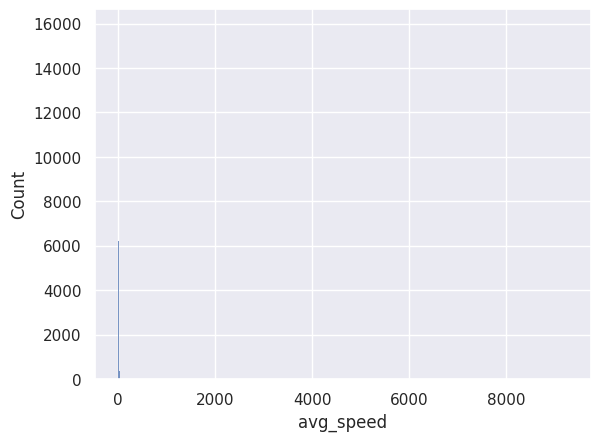

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

# Гистограмма распределения средней скорости
sns.histplot(df['avg_speed'])
plt.show()

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

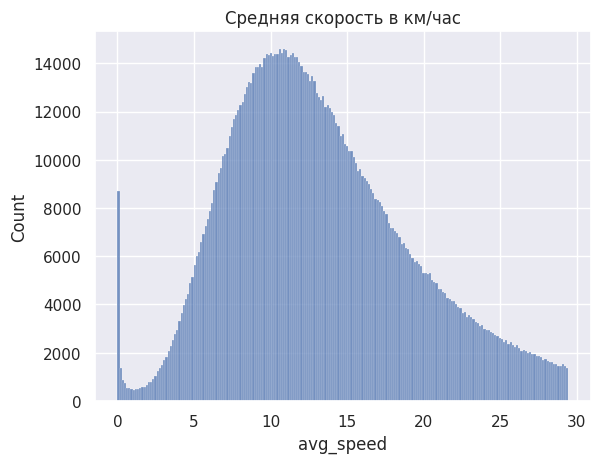

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
speed_limit = df['avg_speed'].quantile(0.95)
df_filtered = df[df['avg_speed'] <= speed_limit]
sns.histplot(df_filtered['avg_speed'])
plt.title("Средняя скорость в км/час")
plt.show()


Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

<Figure size 1500x1000 with 0 Axes>

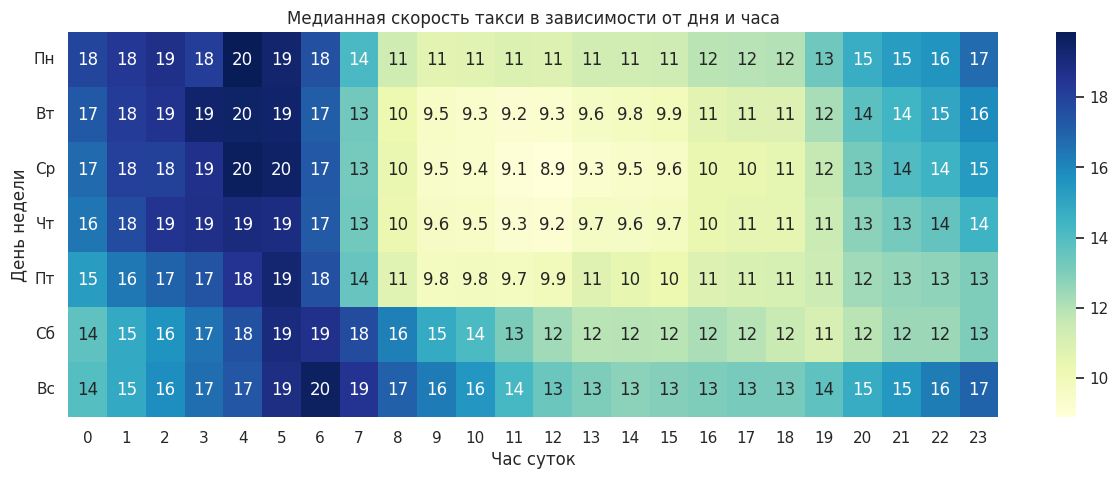

In [ ]:
speed_by_day_hour = df_filtered.groupby(['day_of_week', 'hour'])['avg_speed'].median().unstack()
plt.figure(figsize=(15, 10))
# Создаём список названий дней недели
days = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']

plt.figure(figsize=(15, 5))

# График медианы скорости по дням недели и часам
ax = sns.heatmap(speed_by_day_hour, cmap='YlGnBu', annot=True)

# Устанавливаем подписи для оси Y
ax.set_yticklabels(days, rotation=0)  # Поворот подписей (0 — горизонтально)

plt.xlabel("Час суток")
plt.ylabel("День недели")
plt.title("Медианная скорость такси в зависимости от дня и часа")

plt.show()


Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [ ]:
df.drop(columns=['avg_speed'], inplace=True)

А наша цель – предсказать trip_duration. Если мы включим скорость в модель, это приведёт к утечке данных (data leakage), так как модель сможет «угадывать» время поездки, опираясь на эту зависимость. В реальных условиях (на этапе предсказания) скорость нам не будет доступна,

#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['rush_hour'] = (df['hour'].between(9, 15)) & (df['day_of_week'] < 5)
df['free_road'] = (df['hour'].between(2, 6)) | ((df['hour'].between(20, 24)) | (df['hour'].between(0, 12)) & (df['day_of_week'] >= 5))



**Задание 8 (0.5 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

*можно использовать данные координат из интернета или воспользоваться `from geopy.geocoders import Nominatim`*

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="geoapi")

def reverse_geocode(lat, lon):
    try:
        location = geolocator.reverse((lat, lon), exactly_one=True)
        return location.address
    except:
        return None

# df['pickup_location'] = df.apply(lambda row: reverse_geocode(row['pickup_latitude'], row['pickup_longitude']), axis=1)
# df['dropoff_location'] = df.apply(lambda row: reverse_geocode(row['dropoff_latitude'], row['dropoff_longitude']), axis=1)

# df['start_airport'] = df['pickup_location'].str.contains("Airport").fillna(False).astype(int)
# df['end_airport'] = df['dropoff_location'].str.contains("Airport").fillna(False).astype(int)



KeyError: 'pickup_location'

**Увы, не дождался ответа, слишком долго работает Nominatim для выяснения признака связанного с аэропортом**

Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

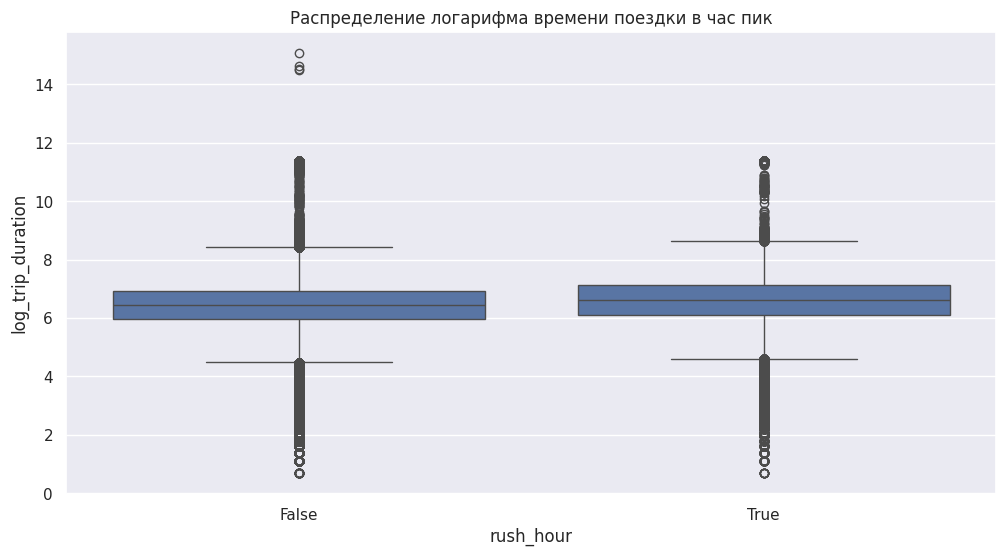

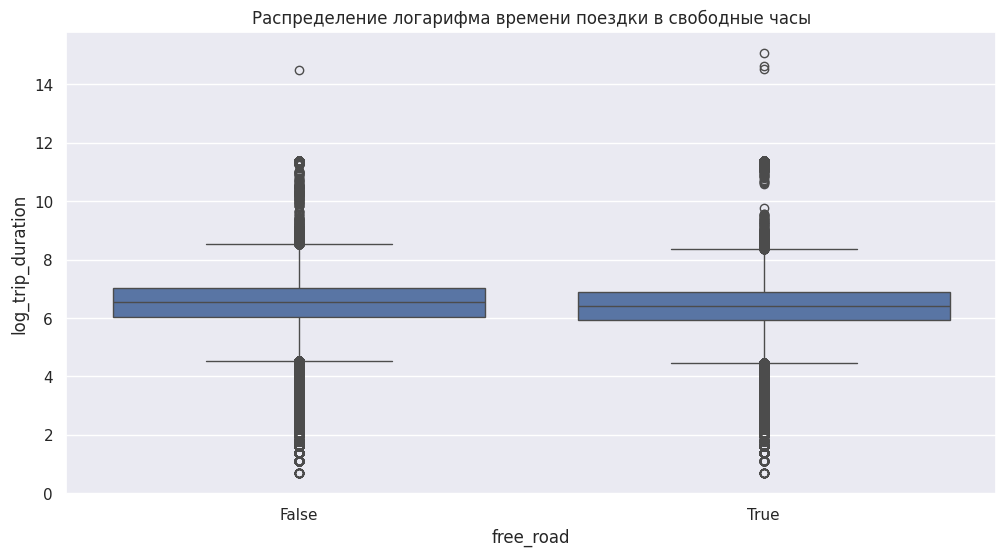

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(x=df['rush_hour'], y=df['log_trip_duration'])
plt.title("Распределение логарифма времени поездки в час пик")
plt.show()
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['free_road'], y=df['log_trip_duration'])
plt.title("Распределение логарифма времени поездки в свободные часы")
plt.show()

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

Видно что медиана и сами ящики с усами смещены для признака rush_hour, free_road друг относительно друга (при rush_hour = True, ящик смещен по оси длительности поездки в большую сторону, логично). Значит получились хорошими

**Задание 9 (0.5 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на всех признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Делим данные на обучающую и тестовую выборки
X = df[['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'day_of_year', 'rush_hour', 'free_road','haversine']]
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Создаем обработку данных для категориальных и численных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['day_of_year','haversine']),
        ('cat', OneHotEncoder(), ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2','rush_hour', 'free_road'])
    ])

# Создаем модель Ridge-регрессии с пайплайном
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Обучаем модель
model.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.424371887302361


Модель улучшилась, причем значительно (было 0.618, стало 0.264)

## Часть 3. Изучаем оставшиеся признаки (1.5 балл)

**Задание 10 (1 балл)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
print(df[['vendor_id', 'passenger_count', 'store_and_fwd_flag']].nunique())


vendor_id              2
passenger_count       10
store_and_fwd_flag     2
dtype: int64


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

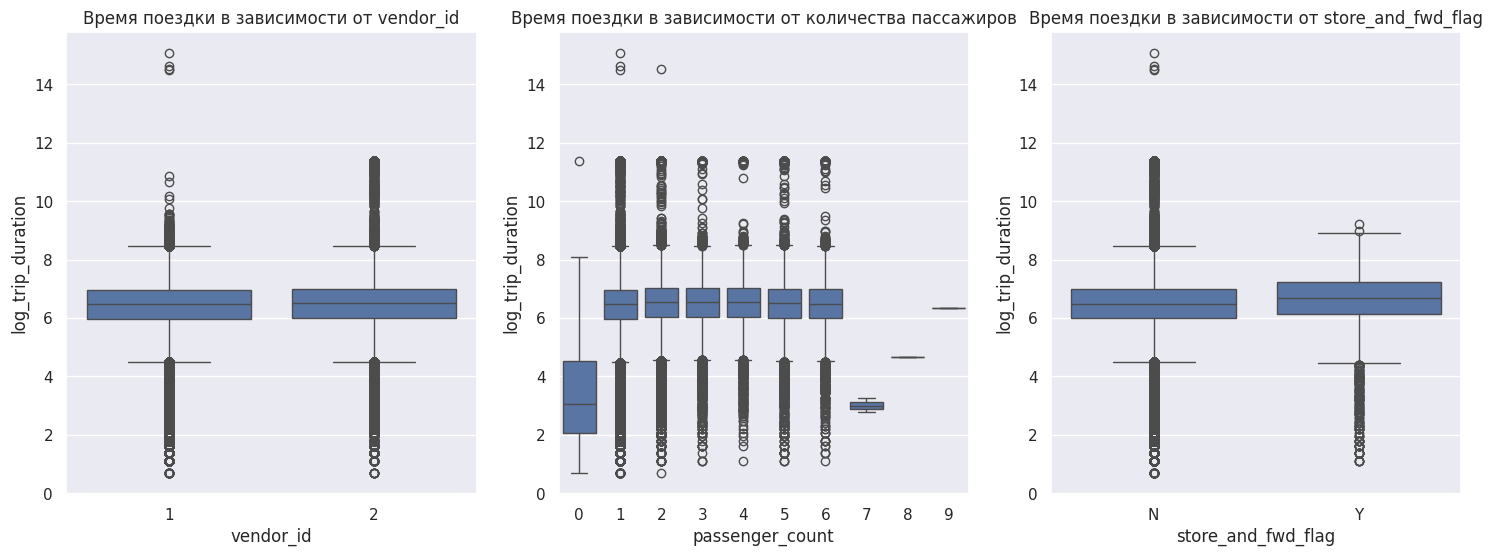

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x=df['vendor_id'], y=df['log_trip_duration'], ax=axes[0])
axes[0].set_title("Время поездки в зависимости от vendor_id")

sns.boxplot(x=df['passenger_count'], y=df['log_trip_duration'], ax=axes[1])
axes[1].set_title("Время поездки в зависимости от количества пассажиров")

sns.boxplot(x=df['store_and_fwd_flag'], y=df['log_trip_duration'], ax=axes[2])
axes[2].set_title("Время поездки в зависимости от store_and_fwd_flag")

plt.show()


Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
df['vendor_id'] = df['vendor_id'].map({1: 0, 2: 1})  # Бинаризация
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})  # Бинаризация


**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

Думаю Vendor_id не сильно полезен (так как ящики с усами смещены друг относительно друга не сильно, значит длительность поездки статистически зависит от vendor_id слабо). store_and_fwd_flag - будет достаточно полезен, так как видно, что при значении Y длительность поездки статистически возрастает заметно.

**Задание 11 (0.5 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Делим данные на обучающую и тестовую выборки
X = df[['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'day_of_year', 'rush_hour', 'free_road','haversine', 'vendor_id', 'store_and_fwd_flag']]
y = df['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Создаем обработку данных для категориальных и численных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['day_of_year','haversine']),
        ('cat', OneHotEncoder(), ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2','rush_hour', 'free_road','vendor_id','store_and_fwd_flag'])
    ])

# Создаем модель Ridge-регрессии с пайплайном
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Обучаем модель
model.fit(X_train, y_train)

# Предсказания на тестовых данных
y_pred = model.predict(X_test)

# Оценка модели
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.4242588954324607


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

In [ ]:
# не дали => выкидываем
# df.drop(columns=['vendor_id'], inplace=True)
# df.drop(columns=['store_and_fwd_flag'], inplace=True)

## Часть 4. Улучшаем модель (3 балла)

**Задание 12 (1.5 балла)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

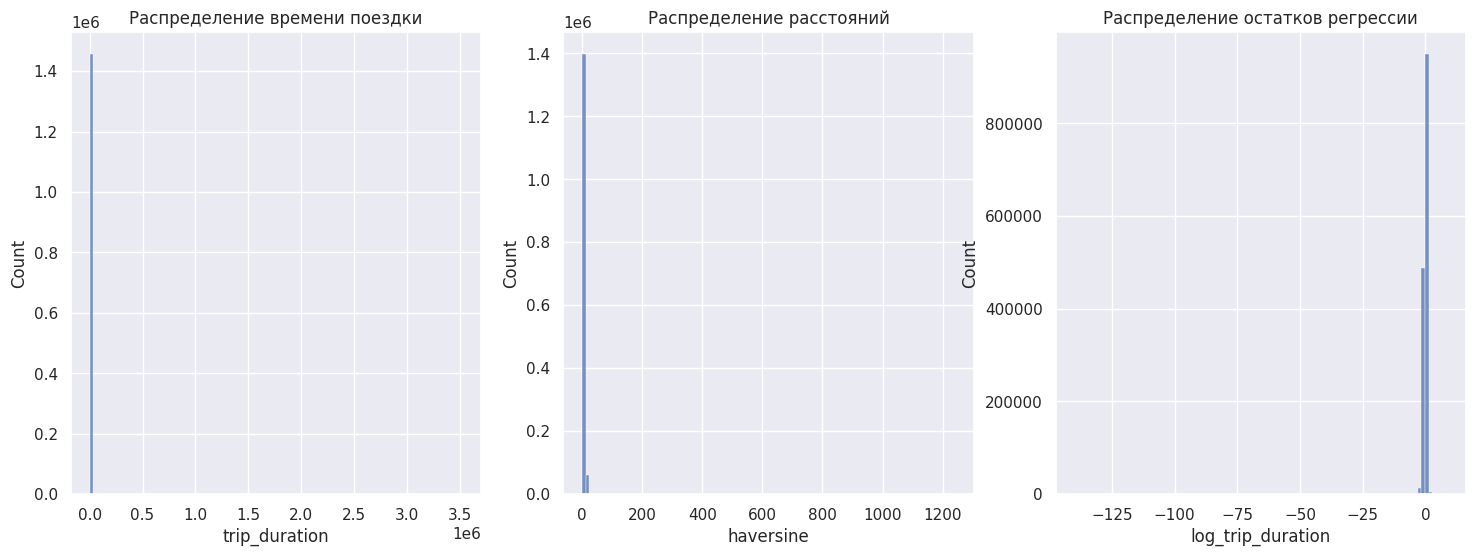

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df['trip_duration'], bins=100, ax=axes[0])
axes[0].set_title("Распределение времени поездки")

sns.histplot(df['haversine'], bins=100, ax=axes[1])
axes[1].set_title("Распределение расстояний")

sns.histplot((y - model.predict(X)), bins=100, ax=axes[2])
axes[2].set_title("Распределение остатков регрессии")

plt.show()

In [ ]:
df_copy =df.copy()


In [ ]:
df_copy['residuals'] = y - model.predict(X)

In [ ]:
# Почистим распределение времени поездки, распределение расстояний по 95-перцентили справа; по остаткам модели чистим слева  по 95-перцентили
def remove_upper_outliers(df, column):
    upper_bound = df[column].quantile(0.95)
    return df[df[column] <= upper_bound]
def remove_lower_outliers(df, column):
    lower_bound = df[column].quantile(0.05)  # 5-й перцентиль
    return df[df[column] >= lower_bound]  # Оставляем только выше границы
# Очищаем данные
df_clean = remove_upper_outliers(df_copy, 'trip_duration')
df_clean = remove_upper_outliers(df_clean, 'trip_duration')
df_clean = remove_lower_outliers(df_clean, 'residuals')
print(f"Удалено {len(df_copy) - len(df_clean)} выбросов из {len(df_copy)} записей ({(len(df_copy) - len(df_clean)) / len(df_copy) * 100:.2f}%)")


Удалено 207974 выбросов из 1458644 записей (14.26%)


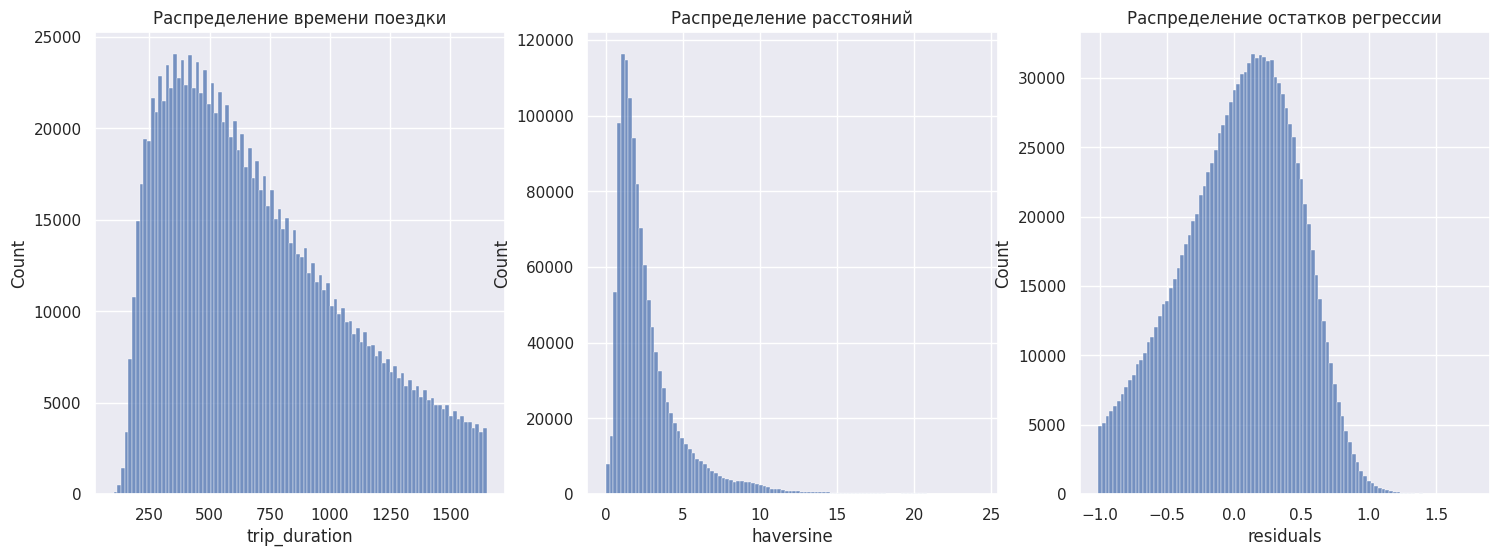

In [ ]:
# нарисуем гистограммы еще раз
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df_clean['trip_duration'], bins=100, ax=axes[0])
axes[0].set_title("Распределение времени поездки")

sns.histplot(df_clean['haversine'], bins=100, ax=axes[1])
axes[1].set_title("Распределение расстояний")

X = df_clean[['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'day_of_year', 'rush_hour', 'free_road','haversine']]
y = df_clean['log_trip_duration']
sns.histplot(df_clean['residuals'] , bins=100, ax=axes[2])
axes[2].set_title("Распределение остатков регрессии")

plt.show()

**Видим что после удаления выбросов стало много лучше**

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# По итогу не можем особо заменить
X = df_clean[['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'day_of_year', 'rush_hour', 'free_road','haversine', 'vendor_id', 'store_and_fwd_flag']]
categorical_columns = ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'rush_hour', 'free_road', 'vendor_id', 'store_and_fwd_flag']
for col in categorical_columns:
    counts = df_clean[col].value_counts()
    rare_categories = counts[counts < 1000].index  # Порог можно менять
    num_replacements = counts[counts < 1000].sum()  # Суммируем количество заменённых значений
    print(f"В столбце '{col}' заменено {num_replacements} значений на 'Other'.")

    df_clean[col] = df_clean[col].replace(rare_categories, 'Other')

В столбце 'day_of_week' заменено 0 значений на 'Other'.
В столбце 'month' заменено 0 значений на 'Other'.
В столбце 'hour' заменено 0 значений на 'Other'.
В столбце 'is_anomalous_period_1' заменено 0 значений на 'Other'.
В столбце 'is_anomalous_period_2' заменено 0 значений на 'Other'.
В столбце 'rush_hour' заменено 0 значений на 'Other'.
В столбце 'free_road' заменено 0 значений на 'Other'.
В столбце 'vendor_id' заменено 0 значений на 'Other'.
В столбце 'store_and_fwd_flag' заменено 0 значений на 'Other'.


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Количество признаков не уменьшилось, так как значений каждой из категорий больше чем 1000**

**Задание 13 (1.5 балла)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
# Проверим количество признаков до OneHot-кодирования
print(f"Количество признаков до кодирования: {df_clean.shape[1]}")

# Определяем категориальные признаки для OneHot-кодирования
categorical_columns =  ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'rush_hour', 'free_road', 'vendor_id', 'store_and_fwd_flag']

# Применяем OneHot-кодирование
df_encoded = pd.get_dummies(df_clean, columns=categorical_columns, drop_first=True)

# Проверим количество признаков после кодирования
print(f"Количество признаков после кодирования: {df_encoded.shape[1]}")


Количество признаков до кодирования: 23
Количество признаков после кодирования: 52


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

# Делим данные на обучающую и тестовую выборки
X = df_clean[['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'day_of_year', 'rush_hour', 'free_road', 'haversine', 'vendor_id', 'store_and_fwd_flag']]
y = df_clean['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Создаем обработку данных для категориальных и численных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['day_of_year', 'haversine']),
        ('cat', OneHotEncoder(), ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'rush_hour', 'free_road', 'vendor_id', 'store_and_fwd_flag'])
    ])

# Создаем модель Ridge-регрессии с пайплайном
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Обучаем модель Ridge
ridge_model.fit(X_train, y_train)

# Предсказания на тестовых данных для Ridge
y_pred_ridge = ridge_model.predict(X_test)

# Оценка модели Ridge
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Ridge - Mean Squared Error: {mse_ridge}')

# Создаем модель Lasso-регрессии с пайплайном
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Обучаем модель Lasso
lasso_model.fit(X_train, y_train)

# Предсказания на тестовых данных для Lasso
y_pred_lasso = lasso_model.predict(X_test)

# Оценка модели Lasso
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Lasso - Mean Squared Error: {mse_lasso}')


Ridge - Mean Squared Error: 0.1738522813534868
Lasso - Mean Squared Error: 0.3070922400717629


Лучше Ridge чем Lasso

Разбейте _обучающую выборку_ на 5 фолдов кросс-валидации. Подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
import numpy as np

# Делим данные на обучающую и тестовую выборки
X = df_clean[['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'day_of_year', 'rush_hour', 'free_road', 'haversine', 'vendor_id', 'store_and_fwd_flag']]
y = df_clean['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Создаем обработку данных для категориальных и численных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['day_of_year', 'haversine']),
        ('cat', OneHotEncoder(), ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'rush_hour', 'free_road', 'vendor_id', 'store_and_fwd_flag'])
    ])

# Параметры для GridSearchCV (логарифмическая сетка для alpha)
param_grid = {
    'regressor__alpha': np.logspace(-2, 2, 5)  # Логарифмическая сетка от 10^-6 до 10^6
}

# Создаем модель Ridge-регрессии с пайплайном
ridge_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Настройка и обучение с кросс-валидацией для Ridge
ridge_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
ridge_search.fit(X_train, y_train)

# Лучшая модель для Ridge
print(f'Лучший параметр alpha для Ridge: {ridge_search.best_params_}')

# Оценка модели на тестовой выборке для Ridge
y_pred_ridge = ridge_search.predict(X_test)
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
print(f'Mean Squared Error для Ridge: {mse_ridge}')

# Создаем модель Lasso-регрессии с пайплайном
lasso_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso())
])

# Настройка и обучение с кросс-валидацией для Lasso
lasso_search = GridSearchCV(lasso_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
lasso_search.fit(X_train, y_train)

# Лучшая модель для Lasso
print(f'Лучший параметр alpha для Lasso: {lasso_search.best_params_}')

# Оценка модели на тестовой выборке для Lasso
y_pred_lasso = lasso_search.predict(X_test)
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
print(f'Mean Squared Error для Lasso: {mse_lasso}')


Лучший параметр alpha для Ridge: {'regressor__alpha': np.float64(0.01)}
Mean Squared Error для Ridge: 0.1738521375866792
Лучший параметр alpha для Lasso: {'regressor__alpha': np.float64(0.01)}
Mean Squared Error для Lasso: 0.18357322631528236


Вывод: Лучший регрессор Lasso работает с alpha = 10^-4, причем откидывается, сейчас посмотрим сколько признаков

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

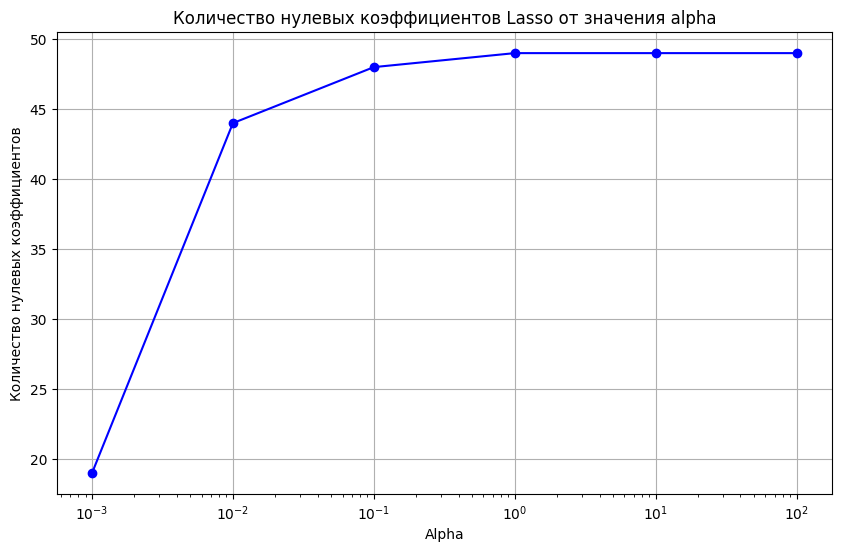

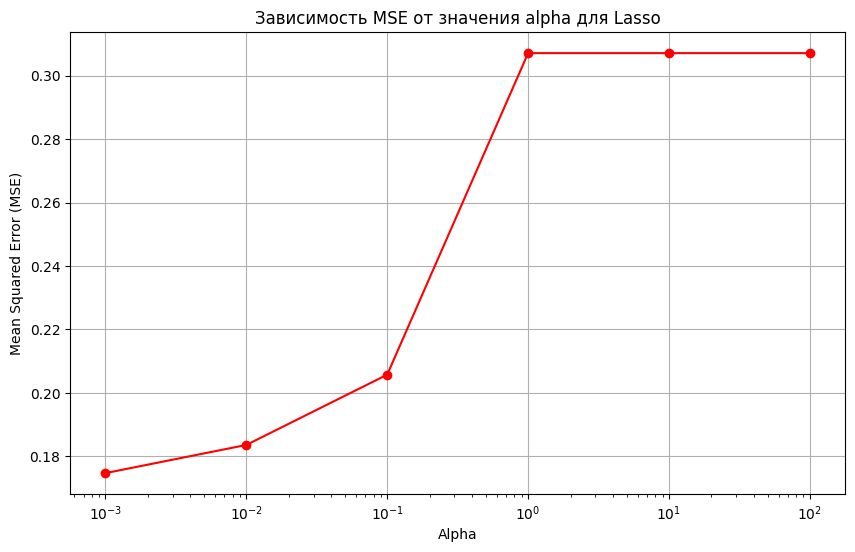

Для alpha = 0.01 мы избавились от хотя бы половины признаков (44 нулевых коэффициентов).
MSE на тестовой выборке: 0.18357322631528236


In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Делим данные на обучающую и тестовую выборки
X = df_clean[['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'day_of_year', 'rush_hour', 'free_road', 'haversine', 'vendor_id', 'store_and_fwd_flag']]
y = df_clean['log_trip_duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Создаем обработку данных для категориальных и численных признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['day_of_year', 'haversine']),
        ('cat', OneHotEncoder(), ['day_of_week', 'month', 'hour', 'is_anomalous_period_1', 'is_anomalous_period_2', 'rush_hour', 'free_road', 'vendor_id', 'store_and_fwd_flag'])
    ])

# Логарифмическая сетка для alpha
alphas = np.logspace(-3, 2, 6)

# Список для хранения количества нулевых весов для каждого alpha
zero_weights = []

# Список для хранения MSE для каждого alpha
mse_list = []

# Проходим по всем значениям alpha
for alpha in alphas:
    # Создаем модель Lasso с текущим alpha
    lasso_model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', Lasso(alpha=alpha))
    ])

    # Обучаем модель
    lasso_model.fit(X_train, y_train)

    # Получаем веса модели
    coefficients = lasso_model.named_steps['regressor'].coef_

    # Считаем количество нулевых весов
    zero_weights.append(np.sum(coefficients == 0))

    # Оценка модели на тестовой выборке
    y_pred_lasso = lasso_model.predict(X_test)
    mse_list.append(mean_squared_error(y_test, y_pred_lasso))

# Строим график зависимости количества нулевых коэффициентов от alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, zero_weights, marker='o', linestyle='-', color='b')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Количество нулевых коэффициентов')
plt.title('Количество нулевых коэффициентов Lasso от значения alpha')
plt.grid(True)
plt.show()

# Строим график зависимости MSE от alpha
plt.figure(figsize=(10, 6))
plt.plot(alphas, mse_list, marker='o', linestyle='-', color='r')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Зависимость MSE от значения alpha для Lasso')
plt.grid(True)
plt.show()

# Определим, при каком значении alpha мы избавимся хотя бы от половины признаков
num_features = X_train.shape[1] + len(preprocessor.transformers_[1][1].get_feature_names_out())  # Все признаки до OneHot
half_features = num_features / 2

for i, alpha in enumerate(alphas):
    if zero_weights[i] >= half_features:
        print(f"Для alpha = {alpha} мы избавились от хотя бы половины признаков ({zero_weights[i]} нулевых коэффициентов).")
        print(f"MSE на тестовой выборке: {mse_list[i]}")
        break


In [ ]:
print("Лучший mse: {}, mse при откинутых 44 из 58 признаков: {}, разница: {}".format(mse_list[0],mse_list[1],-mse_list[0]+mse_list[1]))

Лучший mse: 0.1746935506412889, mse при откинутых 44 из 58 признаков: 0.18357322631528236, разница: 0.008879675673993448


Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.